In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys

sys.path.append("..")

import Models.OWID as owid
import Models.SIRD as sird
import Models.GradDescModels as gdm
import Models.process as process

import warnings
warnings.filterwarnings(action='once')

In [4]:
import csv

def getIndex(A, item):
    index = 0
    while(index < len(A) and A[index] != item):
        index = index + 1
    
    if(index == len(A)):
        return -1 #doesn't exists
    return index #found

import csv
import platform
import os.path
def getCountryDates(countryName, filePathOver=""):
    fileName = "../../Data/Country Policy Data/" #mac file address
    if(filePathOver!=""): #override was set
        fileName = filePathOver
    #pathc="../Data/Covid Tracking State Data/"
    if platform.system() == "Windows":
        fileName.replace("/", "\\")
    fileName = fileName+countryName + ".csv"
    
    if(not os.path.exists(fileName)):
        return []
    
    csvFile = open(fileName, newline='', encoding='UTF-8')
    rd = csv.reader(csvFile, delimiter=',') #reader
    data=[] #the data of all countries
    for lv in rd: #generating the data matrix
        data.append(lv)

    labels = np.array(data[0]) #get the labels
    data = data[1:] #remove the header
    data = np.array(data) #convert to np array for simplicity
    
    return data[:,0].transpose() #just the dates

####################################################################

import csv
def loadDictionaryFromFitFile(fileName):
    inputFile = open(fileName, 'r')
    rd = csv.reader(inputFile, delimiter=',') #reader

    fitDict = {}
    for row in rd:
        fitDict[row[0]] = list(map(float, row[1:]))

    inputFile.close()
    return fitDict


import csv
import platform

def loadCAData(fileName="../../Data/California Test Data/CA.csv"):
    #pathc="../Data/Covid Tracking State Data/"
    if platform.system() == "Windows":
        fileName.replace("/", "\\")

    csvFile = open(fileName, newline='', encoding='UTF-8')
    rd = csv.reader(csvFile, delimiter=',') #reader
    data=[] #the data of all countries
    for lv in rd: #generating the data matrix
        data.append(lv)

    labels = np.array(data[0]) #get the labels
    data = data[1:] #remove the header
    data = np.array(data) #convert to np array for simplicity

    for i in range(len(data)):
        for j in range(len(data[i])):
            if(data[i,j] == ''): #empty cell, convert to 0
                data[i,j] = '0'

    dates = data[:,np.where(labels == "Dates")[0][0]] #the dates column
    dead = data[:,np.where(labels == "Deaths")[0][0]].astype(np.float) #total deaths
    infected = data[:,np.where(labels == "Infected")[0][0]].astype(np.float) #total infections
    tested = data[:,np.where(labels == "Tested")[0][0]].astype(np.float) #total tests

    population = float(data[0,np.where(labels == "Population")[0][0]])

    totalIScaler = infected[-1]/population #the total infected at the end of the period (/pop)
    
    #scale by population
    I = infected/population
    D = dead/population
    
    #there are a couple bad reported days in CA, skip over them.
    sD = 0 #startDate, first day with over .001 infection
    while(I[sD] < .0001):
        sD = sD+1
    dates = dates[sD:]
    D = D[sD:]
    I = I[sD:]
    tested = tested[sD:]

    newI = diffSameSize(I)
    newTests = diffSameSize(tested)

    modNewI = process.scaleNewInfections(newI, newTests) #scale by tests

    I = process.reverseDiff(modNewI) #aggregate
    I = I * (.22/(max(I))) #adjust so it matches max = .1, this is arbitrary
    
    R = process.getRecov(I, D)
    I = I - R - D #change to current infections, instead of total

    sD = 0 #startDate, first day with over .001 infection
    while(I[sD] < .001):
        sD = sD+1

    return dates[sD:],I[sD:],R[sD:],D[sD:], totalIScaler #current infections, recoveries, deaths

def diffSameSize(A):
    B = np.zeros(len(A))
    B[0] = 0 #assume previous day was same as start day
    B[1:] = A[1:] - A[0:-1]
    
    return B

In [21]:
import csv

fitFileName = "..\\..\\Data\\AIRD fits\\ITPieceFit.csv" #the params for the first segment
fitFileAltName = "..\\..\\Data\\AIRD fits\\ITPieceFitAlt2.csv" #the A and I for the last segment
paramsDict = loadDictionaryFromFitFile(fitFileName)

simDates = [225, 250, 275, 285]
finalSegment = 30 #30 days for final fit

dates, I, R, D, V, totI = owid.LoadCountryNormal("Italy")
#I = smooth(IOrig, 14) #smooth out so fitting is better
consts = [len(I), I[0], max(I)]


for simDate in simDates:
    sectionI = I[:simDate]
    constsSection = [simDate, I[0], max(I)]
    
    #params =  gdm.getParams(sectionI, constsSection, randomIterCount=200, lastDay=.3, slopeWeight=2)
    params = paramsDict[str(simDate)]
    
    
    constsSection2 = list(params[2:])
    constsSection2.insert(0, [finalSegment, sectionI[simDate-finalSegment], max(sectionI[simDate-finalSegment:])])
    
    params2 = gdm.getParamsEnd(sectionI[simDate-finalSegment:], constsSection2, randomIterCount=150)
    
    #with open(fitFileName,'a', newline="") as fd: #append the row to fitFileName
    #    writer = csv.writer(fd)
    #    row = params.tolist()
    #    row.insert(0, str(simDate))
    #    writer.writerow(row)
        
    #with open(fitFileAltName,'a', newline="") as fd: #append the row to fitFileName
    #    writer = csv.writer(fd)
    #    row = params2.tolist()
    #    row.insert(0, str(simDate))
    #    writer.writerow(row)
        
    print(simDate, "is done!")

0 New best error:  3.873483840555675e-07
225 is done!   
0 New best error:  5.710576257901107e-07
250 is done!   
0 New best error:  1.615490050382552e-05
275 is done!   6
0 New best error:  1.7522963183263757e-06
285 is done!   


[0.046194314065085416, 0.00033377232752022966, 0.5113068115926617, 0.046808392752896416, 0.0279944394892073, 0.5395214530021301, 31.83999392089647, 1.573141128494617]
[0.046194314065085416, 0.00033377232752022966, 0.5113068115926617, 0.046808392752896416, 0.0279944394892073, 0.5395214530021301, 31.83999392089647, 1.573141128494617] [0.0011260752186980586, 0.0007754937541578032, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


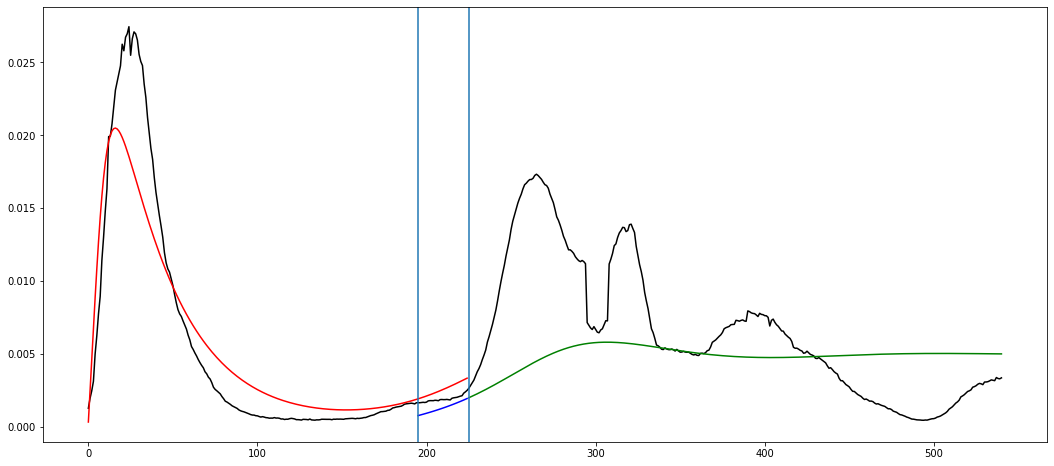

In [39]:

fitFileName = "..\\..\\Data\\AIRD fits\\ITPieceFit.csv" #the A and I for the last segment
fitFileAltName = "..\\..\\Data\\AIRD fits\\ITPieceFitAlt2.csv" #the params for the first segment
paramsDict = loadDictionaryFromFitFile(fitFileName)
params2Dict = loadDictionaryFromFitFile(fitFileAltName)


dates, I, R, D, V, totI = owid.LoadCountryNormal("Italy")
consts = [len(I), I[0], max(I)]
finalSegment = 30

simDate = "225"
params = paramsDict[simDate]

print(params)

params2 = params2Dict[simDate]

print(params, params2)
simDate = int(simDate)


xrange = np.arange(0, len(I), 1)

params2Final = params.copy()
params2Final[0] = params2[0]
params2Final[1] = params2[1]

simA, simI = gdm.simFunc(params2Final, consts, giveA=True)

paramsSim = params.copy()
paramsSim[0] = simA[finalSegment]
paramsSim[1] = simI[finalSegment]

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(I, color="black")
#mid section, first, last section
ax.plot(xrange[0:simDate], gdm.simFunc(params, consts)[0:simDate], color="red")
ax.plot(xrange[simDate-finalSegment:simDate], gdm.simFunc(params2Final, consts)[:finalSegment], color="blue")
ax.plot(xrange[simDate:], gdm.simFunc(paramsSim, consts)[:len(I)-simDate], color="green")

ax.axvline(x=simDate)
ax.axvline(x=simDate-finalSegment)

In [81]:
import csv

fitFileName = "..\\..\\Data\\AIRD fits\\CAPieceB3Fit.csv" #the A and I for the last segment
fitFileAltName = "..\\..\\Data\\AIRD fits\\CAPieceFitAlt.csv" #the params for the first segment
measureDates = getCountryDates("California Closure Data", filePathOver="../../Data/California Test Data/")

#simDates = [280, 380]
simDates=[380]

dates, I, R, D, totI = loadCAData()
#I = smooth(IOrig, 14) #smooth out so fitting is better
consts = [len(I), I[0], max(I)]


for simDate in simDates:
    sectionI = I[:simDate]
    
    measureIndexes = []
    for measure in measureDates:
        measInd = getIndex(dates, measure)
        if(measInd >= len(sectionI)):
            break #out of range, stop here
        measureIndexes.append(measInd)
    measureIndexesAlt = measureIndexes.copy()
    measureIndexesAlt.append(len(sectionI))
    print(measureIndexesAlt)
    
    finalSegment = simDate - measureIndexesAlt[-2]
    
    sectionI = I[:simDate]
    constsSection = [simDate, I[0], max(I), measureIndexesAlt]
    
    params =  gdm.getParamsB2(sectionI, constsSection, randomIterCount=150, lastDay=.3)

    paramsCopy = params[0:8]
    paramsCopy[-1] = params[-1] #use the last beta3 value
    
    constsSection2 = list(paramsCopy[2:])
    constsSection2.insert(0, [finalSegment, sectionI[-finalSegment], max(sectionI[simDate-finalSegment:])])
    
    params2 = gdm.getParamsEnd(sectionI[simDate-finalSegment:], constsSection2, randomIterCount=250, lastDay=.5)
    
    with open(fitFileName,'a', newline="") as fd: #append the row to fitFileName
        writer = csv.writer(fd)
        row = params.tolist()
        row.insert(0, str(simDate))
        writer.writerow(row)
        
    with open(fitFileAltName,'a', newline="") as fd: #append the row to fitFileName
        writer = csv.writer(fd)
        row = params2.tolist()
        row.insert(0, str(simDate))
        writer.writerow(row)
        
    print(simDate, "is done!")

C:\Users\Lemon\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-81-6f049259cb54>:5: ResourceWarning: unclosed file <_io.TextIOWrapper name='../../Data/California Test Data/California Closure Data.csv' mode='r' encoding='UTF-8'>
  measureDates = getCountryDates("California Closure Data", filePathOver="../../Data/California Test Data/")
<ipython-input-81-6f049259cb54>:10: ResourceWarning: unclosed file <_io.TextIOWrapper name='../../Data/California Test Data/CA.csv' mode='r' encoding='UTF-8'>
  dates, I, R, D, totI = loadCAData()
..\Models\GradDescModels.py:286: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (b0/ (1 + (b1*I[t])**(cur

[1, 92, 163, 254, 313, 380]
Iter:  0

..\Models\GradDescModels.py:286: RuntimeWarning: overflow encountered in double_scalars
  diffA = (b0/ (1 + (b1*I[t])**(currB2) ) )*A[t] - gamma0*A[t]


1 New best error:  0.00021344114839131855
3 New best error:  1.822155171433861e-05
14 New best error:  1.6970955584952443e-05
62 New best error:  1.4915794008073036e-05
116 New best error:  9.858319672976149e-06
0 New best error:  2.812376473990815e-06
380 is done!   


[1, 92, 163, 254, 285]
26
[0.023335960281679734, 0.006924096082074895, 0.8905136878686359, 0.020468657441696927, 0.020578600556516512, 1.4456803566439935, 88.86506077629147, 2.1524303406310383, 0.5932411298376067, 1.0337570429519067, 0.6120863661604384, 2.1524303406310383]
[0.010665268051591726, 0.007268409583871373, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.TextIOWrapper name='../../Data/California Test Data/CA.csv' mode='r' encoding='UTF-8'>
  import sys
C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.TextIOWrapper name='../../Data/California Test Data/California Closure Data.csv' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app


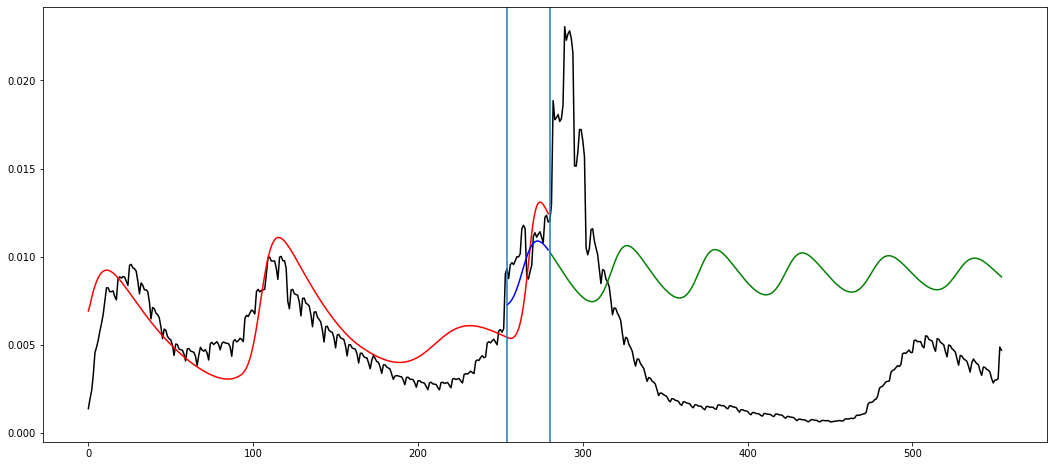

In [33]:

fitFileName = "..\\..\\Data\\AIRD fits\\CAPieceB3Fit.csv" #the A and I for the last segment
fitFileAltName = "..\\..\\Data\\AIRD fits\\CAPieceFitAlt.csv" #the params for the first segment
paramsDict = loadDictionaryFromFitFile(fitFileName)
params2Dict = loadDictionaryFromFitFile(fitFileAltName)


dates, I, R, D, totI = loadCAData()


simDate = "280"
params = paramsDict[simDate]
params2 = params2Dict[simDate]

simDate = int(simDate)
measureDates = getCountryDates("California Closure Data", filePathOver="../../Data/California Test Data/")
measureIndexes = []
for measure in measureDates:
    measInd = getIndex(dates, measure)
    if(measInd >= simDate):
        break #out of range, stop here
    measureIndexes.append(measInd)
measureIndexesAlt = measureIndexes.copy()
measureIndexesAlt.append(len(sectionI))
print(measureIndexesAlt)

finalSegment = simDate - measureIndexesAlt[-2]
print(finalSegment)

print(params)
print(params2)


xrange = np.arange(0, len(I), 1)

params2Final = params[0:8]
params2Final[0] = params2[0]
params2Final[1] = params2[1]

simA, simI = gdm.simFunc(params2Final, consts, giveA=True)

paramsSim = params.copy()
paramsSim[0] = simA[finalSegment]
paramsSim[1] = simI[finalSegment]

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(I, color="black")
#mid section, first, last section
constsSection = [simDate, I[0], max(I), measureIndexesAlt]
ax.plot(xrange[0:simDate], gdm.simFuncB2(params, constsSection)[0:simDate], color="red")
ax.plot(xrange[simDate-finalSegment:simDate], gdm.simFunc(params2Final, consts)[:finalSegment], color="blue")
ax.plot(xrange[simDate:], gdm.simFunc(paramsSim, consts)[:len(I)-simDate], color="green")

ax.axvline(x=simDate)
ax.axvline(x=simDate-finalSegment)